In [1]:
__author__ = "me"
__date__ = "2016_02_01"


import matplotlib
matplotlib.use('Agg')


%pylab inline
import matplotlib.pyplot as plt

import sqlite3
import datetime
import dateutil.parser
import pandas as pd

import os
import ast
from ipynotifyer import notifyOnComplete as nf

Populating the interactive namespace from numpy and matplotlib


In [2]:
def getSQLiteTweets(path):
    '''gets all data as tuple'''
    conn = sqlite3.connect(path)
    data = conn.cursor().execute('SELECT * FROM tweets').fetchall() ## all but raw data
    conn.close()
    return data


@nf
def getDF(path):
    print 'connecting!'
    conn = sqlite3.connect(path)
    print 'aquiring...'    
    columns2 = ('id', 'user_id', 'application', 'postalCode', 'ts')

    return pd.read_sql('SELECT id, user_id, application, postalCode, ts FROM tweets', 
                       conn, parse_dates='ts', columns=columns2)


In [3]:
path = '../../data/MASTERDB/2016-04-15_v4.db'
df = getDF(path)

connecting!
aquiring...


In [4]:
df.shape

(23046861, 5)

In [5]:
df.dtypes

id                      int64
user_id                 int64
application            object
postalCode            float64
ts             datetime64[ns]
dtype: object

## Records total

In [6]:
df.user_id.unique().shape

(665946,)

## Time Range

In [7]:
df['ts'].describe()

count                23046861
unique               16837843
top       2014-06-26 20:33:20
freq                      118
first     2014-01-01 00:00:00
last      2015-06-30 23:03:26
Name: ts, dtype: object

## Sources

## APPS

In [7]:
df.application.unique().shape

(602,)

(0, 100)

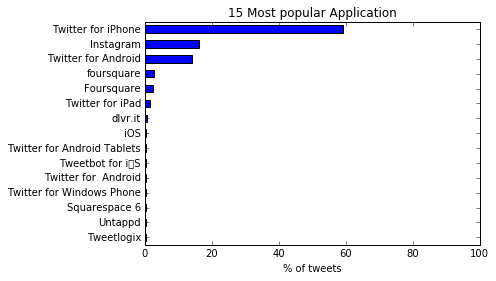

In [21]:
(100*df.application.value_counts().head(15).sort_values(ascending=True)/len(df)).plot(kind='barh')
plt.xlabel('% of tweets')

plt.title('15 Most popular Application')
plt.xlim(0,100)

In [ ]:
# bots = ('CareerCenter', 'SafeTweet by TweetMyJOBS', 'Goldstar', 'TweetMyJOBS','dlvr.it', 'dine here', 'kickalert', 'pbump.net' )

In [ ]:
# df[df.application == 'kickalert'].tweet.head(10)

## USERS

In [11]:
uCount = df.user_id.value_counts()
uCount.describe()

count    665946.000000
mean         34.607702
std         277.856580
min           1.000000
25%           1.000000
50%           4.000000
75%          13.000000
max       78481.000000
Name: user_id, dtype: float64

In [12]:
len(uCount[uCount>1])

484796

In [13]:
singles = uCount[uCount==1].index.tolist()
len(uCount[uCount==1])

181150

In [15]:
top = uCount.head(30).index.tolist()

# df[df.user_id == top[4]].head(20).tweet

In [ ]:
# users not within top21 and not single-shots
len(df[(~df.user_id.isin(top[:21])) & (~ df.user_id.isin(singles)) ])

In [ ]:
# cleanData = df[(~df.user_id.isin(top[:21])) & (~ df.user_id.isin(singles)) ]
cleanData = df[(~df.user_id.isin(top[:21]))]

## Timeline

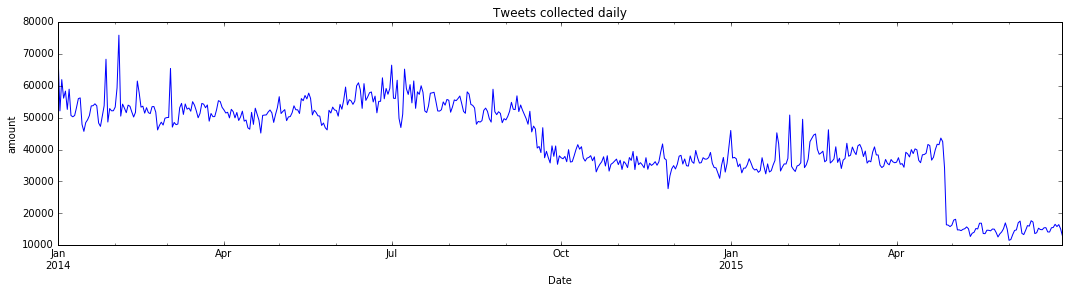

In [22]:
def timeCoverage(df, timeCol='ts', countCol='id', rs='D'):
    dft = df[[timeCol, countCol]].set_index(timeCol).resample(rs, how='count')
    dft.plot(figsize=(18,4), legend=0, title='Tweets collected daily');
    plt.xlabel('Date');
    plt.ylabel('amount');

timeCoverage(df)

## TIME grouping

In [20]:
s = df[['id', 'ts']].set_index('ts').resample('15Min', how='count')

In [21]:
s.reset_index(inplace=1)
s['id'] = s['id'].astype(float)


s['wd'] = s['ts'].dt.weekday
s['hour'] = s['ts'].dt.hour
s['minute'] = s['ts'].dt.minute

sg = s.groupby(['wd', 'hour', 'minute']).agg('mean')
sg.reset_index(inplace=1)

In [22]:
sg.head()

,wd,hour,minute,id
0,0,0,0,710.025641
1,0,0,15,723.346154
2,0,0,30,722.538462
3,0,0,45,738.051282
4,0,1,0,818.987179


In [23]:
sg['timestamp'] = sg.apply(lambda x: datetime.datetime(year=2015, 
                                                       month=1, 
                                                       day=(int(x.wd)+1), 
                                                       hour=int(x.hour), 
                                                       minute=int(x.minute)), 1)

In [24]:
sg.head()

,wd,hour,minute,id,timestamp
0,0,0,0,710.025641,2015-01-01 00:00:00
1,0,0,15,723.346154,2015-01-01 00:15:00
2,0,0,30,722.538462,2015-01-01 00:30:00
3,0,0,45,738.051282,2015-01-01 00:45:00
4,0,1,0,818.987179,2015-01-01 01:00:00


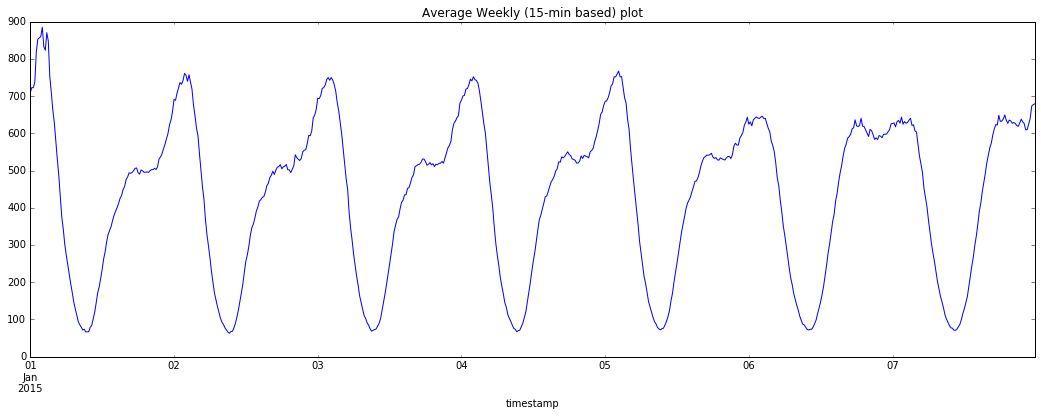

In [25]:
sg[['id', 'timestamp']].set_index('timestamp').plot(figsize=(18,6), legend=0, title='Average Weekly (15-min based) plot');

In [26]:
def averageWeek(df, ax):
    '''calculate average week on ts'''
    
    s = df[['id', 'ts']].set_index('ts').resample('15Min', how='count')
    s.reset_index(inplace=1)
    s['id'] = s['id'].astype(float)

    s['wd'] = s['ts'].dt.weekday
    s['hour'] = s['ts'].dt.hour
    s['minute'] = s['ts'].dt.minute

    sg = s.groupby(['wd', 'hour', 'minute']).agg('mean')
    sg.reset_index(inplace=1)
    
    sg['timestamp'] = sg.apply(lambda x: datetime.datetime(year=2015, 
                                                       month=1, 
                                                       day=(int(x.wd)+1), 
                                                       hour=int(x.hour), 
                                                       minute=int(x.minute)), 1)
    
    sg[['id', 'timestamp']].set_index('timestamp').plot(ax=ax);

## Geography

In [27]:
gdf  = toGeoDataFrame(df, lat='lon',lon='lat')

NameError: name 'toGeoDataFrame' is not defined

In [30]:
import geopandas as gp

In [35]:
zipPath = '../../data/misk/nyc-zip-code-tabulation-areas-polygons.geojson'

In [36]:
zips = gp.read_file(zipPath)

In [38]:
len(zips)

262

NameError: name 'gdf' is not defined

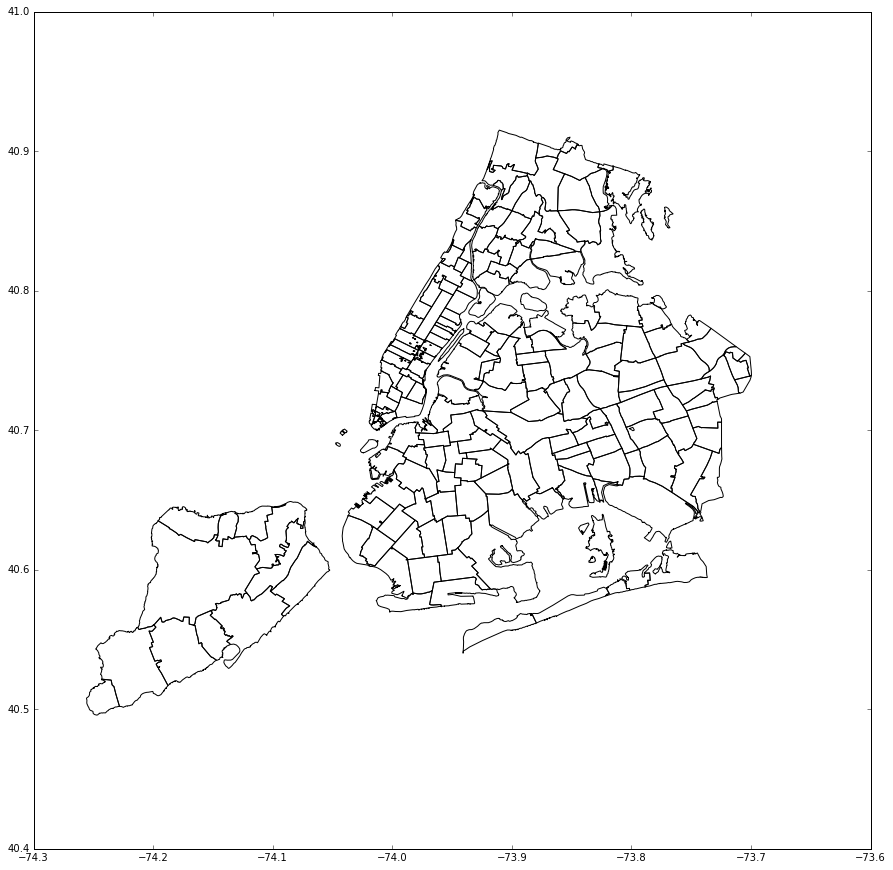

In [37]:
fig,ax = plt.subplots(figsize=(15,15))
zips.plot(alpha=0, ax=ax)
gdf[-10000:].plot(ax=ax)

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))
zips.plot(alpha=0, ax=ax)
gdf[:10000].plot(ax=ax)